In [68]:
import numpy as np
import sys
sys.path.append('..')
from steingp import SVGD, RBF, SteinMC, accuracy, Median
import matplotlib.pyplot as plt
import gpflow
import tensorflow as tf
from utils import get_classification_data

# Load data

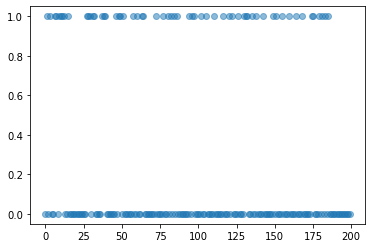

In [71]:
dataset = get_classification_data('breast-cancer', prop=0.7, split=123)
Xtr, Xte, ytr, yte = dataset.return_data()
plt.plot(ytr, 'o', alpha=0.5)

# Define model

In order to run non-Gaussian models and to use kernels in their ARD form, we must define a partitions argument that can be either a list or tuple. The arguments of this should describe the shape of the latent parameters, the kernel lengthscales, and finally the kernel variance.

In [72]:
kern = gpflow.kernels.Matern32(lengthscales = [np.sqrt(Xtr.shape[1])]*Xtr.shape[1])
lik = gpflow.likelihoods.Bernoulli()
m = SteinMC((Xtr, ytr), kernel=kern, likelihood=lik, partitions=[Xtr.shape[0], Xtr.shape[1], 1])

# Instantiate SVGD

In [73]:
opt = SVGD(m, kernel=RBF(Median()), n_particles=10, verbose=True)

### Run SVGD

In [74]:
opt.run(iterations=100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.51it/s]


# Inspect particles

Now that we have non-Gaussian data, there will be a single particle for each of the latent dimensions. For illustrative purposes, we will not plot this, and intead plot the kernel lengthscales and variance.

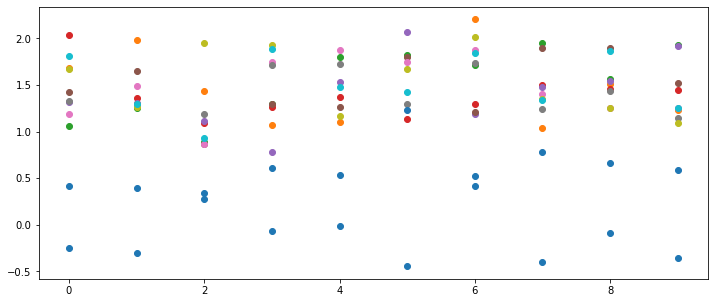

In [75]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))

for t in opt.theta.numpy()[Xtr.shape[0]:]:
    ax.plot(t, 'o')

# Predictions

In [77]:
theta = opt.theta.numpy()
preds = m.predict(Xte, theta, 20)
mu = lik.invlink(np.mean(preds, axis=0))
pred = np.where(mu<0.5, 0, 1)
mu_lower = np.percentile(preds, 5, axis=0)
mu_higher = np.percentile(preds, 95, axis=0)

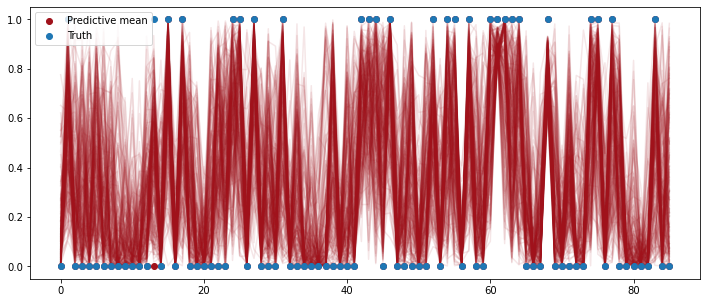

In [78]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(lik.invlink(preds.T), alpha=0.1, color='#a0121b')
ax.plot(pred, 'o', color='#a0121b', label="Predictive mean")
ax.plot(yte, 'o', label='Truth')
handles, labels = ax.get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax.legend(handles, labels, loc='best')

In [79]:
accuracy(mu.numpy().reshape(-1, 1), yte)

0.9883720930232558